In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import heapq
import psycopg2
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

/usr/local/anaconda3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
# query = "select * from crosstab ( 'select dq.event_date, c.label, dq.close_value from company c left join daily_quote dq on c.id = dq.company_id where ibovespa_plus = true and (now() - dq.event_date) <= interval ''3 months'' order by 1, 2', 'select c.label from company c where ibovespa_plus = true order by 1') as ct ( event_date date, \"ABCB4\" numeric, \"ABEV3\" numeric, \"BBAS3\" numeric, \"BBDC3\" numeric, \"BBDC4\" numeric, \"BBSE3\" numeric, \"BRAP4\" numeric, \"BRFS3\" numeric, \"BRKM5\" numeric, \"BRML3\" numeric, \"BRSR6\" numeric, \"BTOW3\" numeric, \"CARD3\" numeric, \"CCRO3\" numeric, \"CIEL3\" numeric, \"CMIG4\" numeric, \"CPLE6\" numeric, \"CSAN3\" numeric, \"CSNA3\" numeric, \"CVCB3\" numeric, \"CYRE3\" numeric, \"ECOR3\" numeric, \"EGIE3\" numeric, \"ELET3\" numeric, \"ELET6\" numeric, \"EMBR3\" numeric, \"ENBR3\" numeric, \"EQTL3\" numeric, \"ESTC3\" numeric, \"FESA4\" numeric, \"FIBR3\" numeric, \"FLRY3\" numeric, \"FRAS3\" numeric, \"GGBR4\" numeric, \"GOAU4\" numeric, \"GOLL4\" numeric, \"GRND3\" numeric, \"HYPE3\" numeric, \"IGTA3\" numeric, \"ITSA3\" numeric, \"ITSA4\" numeric, \"ITUB3\" numeric, \"ITUB4\" numeric, \"JBSS3\" numeric, \"KLBN11\" numeric, \"KROT3\" numeric, \"LAME4\" numeric, \"LREN3\" numeric, \"MGLU3\" numeric, \"MPLU3\" numeric, \"MRFG3\" numeric, \"MRVE3\" numeric, \"MULT3\" numeric, \"NATU3\" numeric, \"PCAR4\" numeric, \"PETR3\" numeric, \"PETR4\" numeric, \"PSSA3\" numeric, \"PTBL3\" numeric, \"QUAL3\" numeric, \"RADL3\" numeric, \"RAIL3\" numeric, \"RENT3\" numeric, \"SANB11\" numeric, \"SANB4\" numeric, \"SAPR3\" numeric, \"SAPR4\" numeric, \"SBSP3\" numeric, \"SMLS3\" numeric, \"SMTO3\" numeric, \"SULA11\" numeric, \"SUZB3\" numeric, \"TAEE11\" numeric, \"TIMP3\" numeric, \"TRPL4\" numeric, \"UGPA3\" numeric, \"UNIP3\" numeric, \"UNIP6\" numeric, \"USIM5\" numeric, \"VALE3\" numeric, \"VIVT4\" numeric, \"VVAR3\" numeric, \"WEGE3\" numeric);"

In [3]:
query = """ 
    select dq.event_date, c.label, dq.close_value
    from company c
    inner join daily_quote dq on c.id = dq.company_id
    where ibovespa = true 
    and (now() - dq.event_date) <= interval '4 months'
    order by dq.event_date, c.label;"""

In [4]:
conn = psycopg2.connect(
            database="postgres",
            user="postgres",
            connect_timeout=3,
            options='-c statement_timeout=3000')
raw_df = pd.read_sql(query, conn)
# df.drop('event_date', axis=1, inplace=True)
conn.close()

In [5]:
raw_df.columns = ['Data', 'Sigla', 'Valor_de_Fechamento']
raw_df.set_index(['Data', 'Sigla'], inplace=True)

In [6]:
df = (raw_df.unstack()
          .replace({0: np.NaN})
          .fillna(method='ffill')
           .dropna(how='any', axis=1)).copy()

#raw_df.to_csv('data/sample_data.csv')

In [7]:
df = df.loc[:, 'Valor_de_Fechamento']
df.head()

Sigla,ABEV3,BBAS3,BBDC3,BBDC4,BBSE3,BRAP4,BRFS3,BRKM5,BRML3,BTOW3,...,SBSP3,SMLS3,SUZB3,TIMP3,UGPA3,USIM5,VALE3,VIVT4,VVAR3,WEGE3
Data,,,,,,,,,,,,,,,,,,,,,
2018-10-22,16.82,39.85,28.93,33.25,26.53,34.39,20.62,53.40,11.67,35.40,...,28.30,37.40,40.71,11.05,39.79,10.45,58.37,38.42,4.84,18.65
2018-10-23,16.63,39.99,29.01,33.37,26.35,33.60,20.54,52.90,11.71,35.20,...,28.20,37.00,40.99,11.02,40.01,10.20,56.75,38.45,5.35,19.20
2018-10-24,15.89,39.10,28.19,32.57,25.75,32.30,20.13,51.12,11.42,34.23,...,27.73,35.18,42.00,10.68,39.18,9.70,54.43,37.52,5.00,19.35
2018-10-25,15.00,40.10,29.40,33.51,26.36,32.88,20.15,50.66,11.68,34.65,...,27.69,35.00,42.23,10.75,41.31,9.90,54.61,38.00,5.30,19.01
2018-10-26,15.19,42.42,29.73,34.09,26.03,33.34,20.48,49.90,12.00,34.21,...,27.80,36.90,39.50,10.63,42.50,10.06,55.60,37.97,5.38,18.08


In [8]:
abev3 = df.loc[:, 'ABEV3'][:5]
abev3
abev3 / abev3.shift(1) - 1

Data
2018-10-22         NaN
2018-10-23   -0.011296
2018-10-24   -0.044498
2018-10-25   -0.056010
2018-10-26    0.012667
Name: ABEV3, dtype: float64

In [9]:
df.head(5)

Sigla,ABEV3,BBAS3,BBDC3,BBDC4,BBSE3,BRAP4,BRFS3,BRKM5,BRML3,BTOW3,...,SBSP3,SMLS3,SUZB3,TIMP3,UGPA3,USIM5,VALE3,VIVT4,VVAR3,WEGE3
Data,,,,,,,,,,,,,,,,,,,,,
2018-10-22,16.82,39.85,28.93,33.25,26.53,34.39,20.62,53.40,11.67,35.40,...,28.30,37.40,40.71,11.05,39.79,10.45,58.37,38.42,4.84,18.65
2018-10-23,16.63,39.99,29.01,33.37,26.35,33.60,20.54,52.90,11.71,35.20,...,28.20,37.00,40.99,11.02,40.01,10.20,56.75,38.45,5.35,19.20
2018-10-24,15.89,39.10,28.19,32.57,25.75,32.30,20.13,51.12,11.42,34.23,...,27.73,35.18,42.00,10.68,39.18,9.70,54.43,37.52,5.00,19.35
2018-10-25,15.00,40.10,29.40,33.51,26.36,32.88,20.15,50.66,11.68,34.65,...,27.69,35.00,42.23,10.75,41.31,9.90,54.61,38.00,5.30,19.01
2018-10-26,15.19,42.42,29.73,34.09,26.03,33.34,20.48,49.90,12.00,34.21,...,27.80,36.90,39.50,10.63,42.50,10.06,55.60,37.97,5.38,18.08


In [10]:
column_names = df.columns.values
for cn in column_names:
    df[cn] = (df[cn] / df[cn].shift(1) - 1).fillna(0)    

In [11]:
df.head(5)

Sigla,ABEV3,BBAS3,BBDC3,BBDC4,BBSE3,BRAP4,BRFS3,BRKM5,BRML3,BTOW3,...,SBSP3,SMLS3,SUZB3,TIMP3,UGPA3,USIM5,VALE3,VIVT4,VVAR3,WEGE3
Data,,,,,,,,,,,,,,,,,,,,,
2018-10-22,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-10-23,-0.011296,0.003513,0.002765,0.003609,-0.006785,-0.022972,-0.003880,-0.009363,0.003428,-0.005650,...,-0.003534,-0.010695,0.006878,-0.002715,0.005529,-0.023923,-0.027754,0.000781,0.105372,0.029491
2018-10-24,-0.044498,-0.022256,-0.028266,-0.023974,-0.022770,-0.038690,-0.019961,-0.033648,-0.024765,-0.027557,...,-0.016667,-0.049189,0.024640,-0.030853,-0.020745,-0.049020,-0.040881,-0.024187,-0.065421,0.007813
2018-10-25,-0.056010,0.025575,0.042923,0.028861,0.023689,0.017957,0.000994,-0.008998,0.022767,0.012270,...,-0.001442,-0.005117,0.005476,0.006554,0.054364,0.020619,0.003307,0.012793,0.060000,-0.017571
2018-10-26,0.012667,0.057855,0.011224,0.017308,-0.012519,0.013990,0.016377,-0.015002,0.027397,-0.012698,...,0.003973,0.054286,-0.064646,-0.011163,0.028807,0.016162,0.018129,-0.000789,0.015094,-0.048922


In [12]:
# df.dropna(axis=1, how='all', inplace=True)
# df.dropna(axis=0, how='any', inplace=True)
# df.fillna(axis=1, value=0, inplace=True)

In [13]:
#scaler = MinMaxScaler(feature_range=(0, 1))
#df[df.columns] = scaler.fit_transform(df[df.columns])
#df.head()

In [14]:
# series = df.mean()
# series2 = series[series > 0]
# series2

In [15]:
means = np.mean(df)
# print(means)
# variances = np.var(df)
# print(variances)
covariance_matrix = np.cov(df, rowvar=False)
# print(covariance_matrix)

In [16]:
def risk_profit(a):
    return np.sqrt(np.dot(np.dot(a, covariance_matrix), a)), np.sum(np.multiply(a, means))

### Função multi-objetivo
A função f tentará minimizar a variancia da carteira e maximizar o seu retorno

In [17]:
def f(x):
    # return 1 / np.sum(np.multiply(x, means)) # maximiza o lucro
    # return np.dot(np.dot(x, covariance_matrix), x) # minimiza o risco
    return np.dot(np.dot(x, covariance_matrix), x) / np.sum(np.multiply(x, means))

SLSQP - Sequential Least Squares Programming

SLSQP optimizer is a sequential least squares programming algorithm which uses the Han–Powell quasi–Newton method with a BFGS update of the B–matrix and an L1–test function in the step–length algorithm. The optimizer uses a slightly modified version of Lawson and Hanson’s NNLS nonlinear least-squares solver. [Kraft1988] [LICENSE]

http://www.pyopt.org/reference/optimizers.slsqp.html

In [18]:
cons = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1.0}]
n = df.shape[1]
x0 = np.full(n, 1/n)
result = minimize(f, x0, constraints=cons, method='SLSQP', options={'disp': 'True', 'maxiter': 1000})
# result = minimize(f, x0, method='Powell', options={'disp': 'True', 'maxiter': 100})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.005181873654555904
            Iterations: 77
            Function evaluations: 4853
            Gradient evaluations: 77


### Representação visual da carteira otimizada!

risk=0.005513574120728331, profit=0.005866507292789346


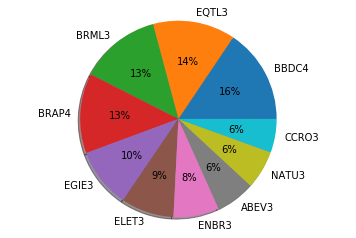

[0.704369532581071, 0.6137424677295159, 0.6032614486722084, 0.5932446588827233, 0.4455958408479314, 0.3930081880732052, 0.3393927604644984, 0.2891496680312952, 0.2873186322966663, 0.2500838725014261]
['BBDC4', 'EQTL3', 'BRML3', 'BRAP4', 'EGIE3', 'ELET3', 'ENBR3', 'ABEV3', 'NATU3', 'CCRO3']


In [19]:
optimal_values = []
optimized = result.success
if optimized:
    risk, profit = risk_profit(result.x)
    #print(result.x)
    print("risk=%s, profit=%s" % (risk, profit))
    
    optimal_values = result.x

#     for k, v in enumerate(optimal_values):
#         print('k = %s, v = %s' % (k, v))

    nlargest = heapq.nlargest(10, enumerate(optimal_values), key=lambda x: x[1])
    nlargest_indexes = [i for (i, j) in nlargest]
    nlargest_values = [j for (i, j) in nlargest]
    labels = [label for label in df.columns[nlargest_indexes].values]
    fig1, ax1 = plt.subplots()
    ax1.pie(nlargest_values, labels=labels, shadow=True, autopct='%1.0f%%')
    ax1.axis('equal')
    plt.show()
    print(nlargest_values)
    print(labels)
else:
    print('FUNCTION COULD NOT BE OPTIMIZED!')

In [20]:
sum_value = np.sum(nlargest_values)
percentages = np.round((nlargest_values / sum_value) * 100)
result = zip(percentages, labels)
print(list(result))
print(labels)

[(16.0, 'BBDC4'), (14.0, 'EQTL3'), (13.0, 'BRML3'), (13.0, 'BRAP4'), (10.0, 'EGIE3'), (9.0, 'ELET3'), (8.0, 'ENBR3'), (6.0, 'ABEV3'), (6.0, 'NATU3'), (6.0, 'CCRO3')]
['BBDC4', 'EQTL3', 'BRML3', 'BRAP4', 'EGIE3', 'ELET3', 'ENBR3', 'ABEV3', 'NATU3', 'CCRO3']
